In [14]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os


# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session
#ignore warning
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import load_model
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# **1. DETECT FACES**

**install mtcnn**

In [15]:
!pip install mtcnn

confirm that the library was installed correctly by importing the library and printing the version.

In [16]:
import mtcnn
print(mtcnn.__version__)

0.1.0


The first step is to load an image as a NumPy array, which we can achieve using the PIL library and the open() function. We will also convert the image to RGB, just in case the image has an alpha channel or is black and white.

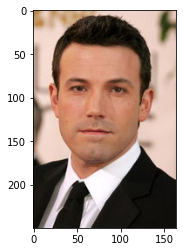

In [17]:
# load image from file
from PIL import Image
image = Image.open('../input/5-celebrity-faces-dataset/train/ben_afflek/httpimagesfandangocomrImageRendererredesignstaticimgnoxportraitjpgpcpcpcimagesmasterrepositoryperformerimagespjpg.jpg')
# convert to RGB, if needed

image = image.convert('RGB')
# convert to array
pixels = np.asarray(image)
plt.imshow(image)

Next, we can create an MTCNN face detector class and use it to detect all faces in the loaded photograph.

In [18]:
detector = mtcnn.MTCNN()
results = detector.detect_faces(pixels)
results

[{'box': [28, 43, 93, 126],
  'confidence': 0.9995970129966736,
  'keypoints': {'left_eye': (53, 89),
   'right_eye': (96, 91),
   'nose': (71, 117),
   'mouth_left': (53, 140),
   'mouth_right': (91, 141)}}]

Draw a rectangle arround the face using result retutn

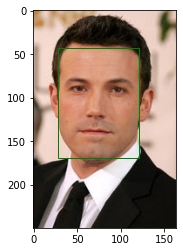

In [19]:
x = abs(results[0]['box'][0])
y = abs(results[0]['box'][1])
xd = results[0]['box'][2]
yd = results[0]['box'][3]
x2 = x + xd
y2 = y +yd
fig, ax = plt.subplots()
rect = patches.Rectangle((x, y), xd, yd, linewidth=1, edgecolor='g', facecolor='none')
ax.add_patch(rect)
ax.imshow(image)
plt.show()

use the coordinates to extract the face.

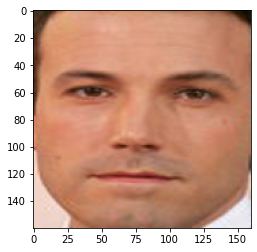

In [20]:
face = pixels[y:y2, x:x2]
image = Image.fromarray(face)
image = image.resize((160, 160))
plt.imshow(image)

Typing all of this together, the function extract_face() will load a photograph from the loaded filename and return the extracted face. It assumes that the photo contains one face and will return the first face detected.

In [21]:
def extract_faces(filename):
    image = Image.open(filename)
    # convert to RGB, if needed
    image = image.convert('RGB')
    # convert to array
    pixels = np.asarray(image)
    detector = mtcnn.MTCNN()
    results = detector.detect_faces(pixels)
    x = abs(results[0]['box'][0])
    y = abs(results[0]['box'][1])
    xd = results[0]['box'][2]
    yd = results[0]['box'][3]
    x2 = x + xd
    y2 = y + yd
    face = pixels[y:y2, x:x2]
    image = Image.fromarray(face)
    image = image.resize((160, 160))
    face_array = np.asarray(image)
    return (face_array)

# 2. Face Classification System

1 (160, 160, 3)
2 (160, 160, 3)
3 (160, 160, 3)
4 (160, 160, 3)
5 (160, 160, 3)
6 (160, 160, 3)
7 (160, 160, 3)
8 (160, 160, 3)
9 (160, 160, 3)
10 (160, 160, 3)
11 (160, 160, 3)
12 (160, 160, 3)
13 (160, 160, 3)
14 (160, 160, 3)


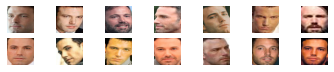

In [22]:
from os import listdir
from os.path import isdir

i = 1
folder = '../input/5-celebrity-faces-dataset/train/ben_afflek/'
for filename in listdir(folder):
    path = folder + filename
    face = extract_faces(path)
    print(i, face.shape)
    plt.subplot(7, 7, i)
    plt.axis('off')
    plt.imshow(face)
    i += 1
    

Tansform the previous code to a function to load_faces() that take a folder name and return all faces

In [23]:
def load_faces(folder):
    faces = list()
    for filename in listdir(folder):
        path = folder + filename
        face = extract_faces(path)
        faces.append(face)
    return (faces)

The load_dataset function below will return a list of images and a label name that we eill take it from folder name. We will implement this function in the train and the  val folder.

In [24]:
def load_data(folder):
    x, y = list(), list()
    for subdir in listdir(folder):
        path = folder + subdir +'/'
        if not isdir(path):
            continue
        faces = load_faces(path)
        labels = [subdir] * len(faces)
        x.extend(faces)
        y.extend(labels)
    return np.asarray(x), np.asarray(y)

Load train Data and test Data (generate a face embeded that the model will use to classificy the new data)

In [26]:
x_train, y_train = load_data('/kaggle/input/5-celebrity-faces-dataset/train/')
x_test, y_test = load_data('/kaggle/input/5-celebrity-faces-dataset/val/')
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((93, 160, 160, 3), (93,), (25, 160, 160, 3), (25,))

Save the data in a zip file to use it next time, without neeed to build it again,

In [27]:
np.savez_compressed('5-celebrity-faces.npz', x_train, y_train, x_test, y_test)

Load the Data from the Zip file

In [28]:
data = np.load('5-celebrity-faces.npz')
x_train, y_train, x_test, y_test = data['arr_0'], data['arr_1'], data['arr_2'], data['arr_3']
print('Dataset: train=%d, test=%d' % (x_train.shape[0], x_test.shape[0]))


Dataset: train=93, test=25


Load the FaceNet model ready for converting faces into face embeddings.

In [29]:
# load the model
model = load_model('../input/facenet-keras/facenet_keras.h5')
# summarize input and output shape
print(model.inputs)
print(model.outputs)

[<KerasTensor: shape=(None, 160, 160, 3) dtype=float32 (created by layer 'input_1')>]
[<KerasTensor: shape=(None, 128) dtype=float32 (created by layer 'Bottleneck_BatchNorm')>]


To predict an embedding, first the pixel values of the image need to be suitably prepared to meet the expectations of the FaceNet model. This specific implementation of the FaceNet model expects that the pixel values are standardized, and we have to expand the dimension so that the face array is one simple, all that wille be in get_embedding() function

In [30]:
def get_embidding(model, face_pixels):
    # scale pixel values
    face_pixels = face_pixels.astype('float32')
    # standardize pixel values across channels (global)
    mean, std = face_pixels.mean(), face_pixels.std()
    face_pixels = (face_pixels - mean) / std
    # transform face into one sample
    samples = np.expand_dims(face_pixels, axis=0)
    # make prediction to get embedding
    prediction = model.predict(samples)
    return prediction[0]

Now we will convert each face in our data to faceembidding using the above function

In [ ]:
#transform train_data_x
x_train_embd = list()
for face_pixel in x_train:
    embd = get_embidding(model, face_pixel)
    x_train_embd.append(embd)
x_train_embd = np.asarray(x_train_embd)

#transform test_data_x
x_test_embd = list()
for face_pixel in x_test:
    embd = get_embidding(model, face_pixel)
    x_test_embd.append(embd)
x_test_embd = np.asarray(x_test_embd)
x_test_embd.shape, x_train_embd.shape

((25, 128), (93, 128))

## **Perform Face Classification**

In [32]:
from sklearn import preprocessing
from sklearn.preprocessing import Normalizer
# normalize input vectors

in_encoder = Normalizer(norm='l2')
x_train_embd = in_encoder.transform(x_train_embd)
x_test_embd = in_encoder.transform(x_test_embd)
x_test_embd, x_train_embd

(array([[ 0.00675686,  0.10945795, -0.17908265, ..., -0.02079134,
         -0.13243005,  0.08288195],
        [ 0.01595601,  0.06072197, -0.07696263, ..., -0.02320794,
         -0.02828512,  0.10563938],
        [-0.03154328,  0.05016923, -0.00198367, ...,  0.0325078 ,
         -0.11405461,  0.08639365],
        ...,
        [-0.10621867, -0.07511504, -0.17441477, ..., -0.17184459,
          0.16391413,  0.14840628],
        [-0.08907225,  0.0180109 , -0.05606574, ..., -0.17630367,
          0.16169722,  0.11918713],
        [-0.09677722,  0.04301952, -0.10135804, ..., -0.27063197,
          0.03109113,  0.19746034]], dtype=float32),
 array([[-0.0647032 , -0.00910822, -0.12378421, ...,  0.0365837 ,
         -0.04550656,  0.08252349],
        [-0.02206995,  0.08842105, -0.05012031, ..., -0.10604111,
         -0.02116632,  0.14006725],
        [-0.02947195,  0.03321904, -0.05351494, ..., -0.0851298 ,
         -0.08725797,  0.08936819],
        ...,
        [ 0.05296684,  0.03231524, -0.1

Next, the string target variables for each celebrity name need to be converted to integers.

In [33]:
# label encode targets
out_encoder = preprocessing.LabelEncoder()
out_encoder.fit(y_train)
y_train = out_encoder.transform(y_train)
y_test = out_encoder.transform(y_test)
y_test

array([0, 0, 0, 0, 0, 4, 4, 4, 4, 4, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 1, 1,
       1, 1, 1])

To build a classification model we can use SVM (SVC) algorithm that is more acurate, then we will train our model.

In [34]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score 

model = SVC(kernel='linear', probability=True)

#train the project
model.fit(x_test_embd, y_test)

y_predect_train = model.predict(x_train_embd)
y_predect_test = model.predict(x_test_embd)
#calcule the ACURRACY
score_train = accuracy_score(y_train, y_predect_train)
score_test = accuracy_score(y_test, y_predect_test)
print("accuracy for tarin data : {}\naccuracy for test data  : {}".format(score_train * 100, score_test  * 100))

accuracy for tarin data : 100.0
accuracy for test data  : 100.0


In [35]:
def load_data_2(folder):
    x, y = list(), list()
    for filename in listdir(folder):
        path = folder + filename
        face = extract_faces(path)
        labels = [filename]
        x.append(face)
        y.extend(labels)
    return np.asarray(x), np.asarray(y)

In [38]:
folder = '/kaggle/input/inputforfaceregognition/input/newimagefortest/'
new_faces, new_names = load_data_2(folder)
model_embedd = load_model('../input/facenet-keras/facenet_keras.h5')
i = 0
for face in new_faces:
    face_embd = get_embidding(model_embedd, np.asarray(face))
    prob = model.predict_proba([face_embd])
    out = model.predict([face_embd])
    out_name = out_encoder.inverse_transform(out)
    print("predict name :  ", out_name[0], "  with prob :  ", prob[0, out] * 100 , "   correct name is :       ", new_names[i][:-5])
    i += 1

predict name :   jerry_seinfeld   with prob :   [99.99999173]    correct name is :        jerry_seinfeld
predict name :   mindy_kaling   with prob :   [100.]    correct name is :        mindy_kalling
predict name :   madonna   with prob :   [99.99999184]    correct name is :        madonna
predict name :   elton_john   with prob :   [99.99997924]    correct name is :        elton_john
predict name :   ben_afflek   with prob :   [99.99997041]    correct name is :        ben_afflek


We will test our model using new image one image for each label

In [42]:
# Train the model
model.fit(x_test_embd, y_test)

# Predict labels for training and testing data
y_pred_train = model.predict(x_train_embd)
y_pred_test = model.predict(x_test_embd)

# Calculate accuracy scores
score_train = accuracy_score(y_train, y_pred_train)
score_test = accuracy_score(y_test, y_pred_test)

print("Accuracy for training data: {:.2f}%".format(score_train * 100))
print("Accuracy for test data: {:.2f}%".format(score_test * 100))

Accuracy for training data: 100.00%
Accuracy for test data: 100.00%


TypeError: xticks(): Parameter 'labels' can't be set without setting 'ticks'

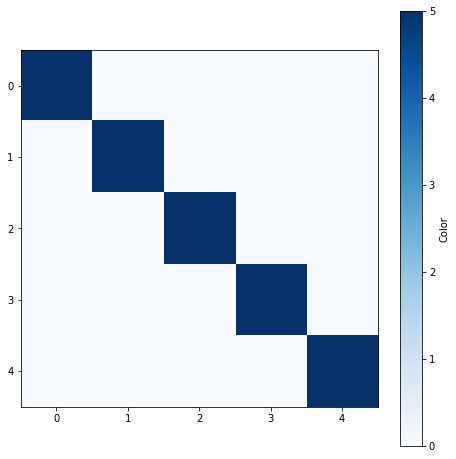

In [47]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

# Get predictions for test data
y_pred = model.predict(x_test_embd)

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Create a visualization of the confusion matrix
plt.figure(figsize=(8, 8))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.colorbar(label='Color')
plt.xticks(tick_positions=np.arange(len(out_encoder.classes_)), labels=out_encoder.classes_)
plt.yticks(tick_positions=np.arange(len(out_encoder.classes_)), labels=out_encoder.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.text(np.arange(len(out_encoder.classes_)), np.arange(len(out_encoder.classes_)), cm.flatten(), ha='center', va='center')
plt.show()

# Define training parameters
epochs = 10
batch_size = 32




In [48]:
from sklearn.metrics import roc_curve, auc

# Get probabilities from the model
y_pred_prob = model.predict_proba(x_test_embd)[:, 1]

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--', label='No Skill')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()


ValueError: multiclass format is not supported